# From Noise to Structure: Building a Diffusion Model on Two Moons

In [1]:
# Install only if needed
# Uncomment and run if libraries are missing
#!pip install torch matplotlib scikit-learn imageio==2.37.0 tqdm

In [2]:
# Configuration-driven universal setup cell
import os
import sys
from pathlib import Path

# Fix OpenMP issues
os.environ['KMP_DUPLICATE_LIB_OK'] = 'TRUE'

# Centralized configuration
IMPORT_CONFIG = {
    'utils': ['get_data'],
    'visualization': ['get_color_palette','plot_real_data'],
    'diffusion': ['get_alpha_bar', 'positional_encoding', 'ScoreModel', 'ddim_sample'],
    'training': ['train_model']
}

def setup_imports():
    """Setup imports using configuration."""
    
    # Try package imports first
    try:
        imported_functions = {}
        for module, functions in IMPORT_CONFIG.items():
            mod = __import__(f'src.{module}', fromlist=functions)
            for func_name in functions:
                imported_functions[func_name] = getattr(mod, func_name)
        
        print("Package imports successful")
        return imported_functions
    except ImportError:
        pass
    
    # Try direct path imports
    try:
        src_path = Path("src").resolve()
        if src_path.exists() and str(src_path) not in sys.path:
            sys.path.insert(0, str(src_path))
        
        imported_functions = {}
        for module, functions in IMPORT_CONFIG.items():
            mod = __import__(module, fromlist=functions)
            for func_name in functions:
                imported_functions[func_name] = getattr(mod, func_name)
        
        print("Direct imports successful")
        return imported_functions
    except ImportError:
        pass
    
    # Try parent directory
    try:
        src_path = Path("../src").resolve()
        if src_path.exists() and str(src_path) not in sys.path:
            sys.path.insert(0, str(src_path))
        
        imported_functions = {}
        for module, functions in IMPORT_CONFIG.items():
            mod = __import__(module, fromlist=functions)
            for func_name in functions:
                imported_functions[func_name] = getattr(mod, func_name)
        
        print("Parent directory imports successful")
        return imported_functions
    except ImportError:
        pass
    
    raise ImportError("Could not import required modules from src/")

# Setup imports
try:
    imports = setup_imports()
    globals().update(imports)  # Add all to global namespace
    print("All imports ready")
except Exception as e:
    print(f"Import setup failed: {e}")
    raise

# Test
try:
    x_real = get_data(100, normalize=False)  # Uses the imported function
    print(f"Test successful: {x_real.shape}")
except Exception as e:
    print(f"Test failed: {e}")

Parent directory imports successful
All imports ready
Test successful: torch.Size([100, 2])


In [3]:
# IMPORTS
import numpy as np
import torch
import matplotlib.pyplot as plt
import math

# Optional: imageio for GIFs
try:
    import imageio
except ImportError:
    print("imageio not installed — animations disabled")

# CONFIG
# Device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Seeds
torch.manual_seed(42)
np.random.seed(42)


figures_path = Path("../figures").resolve()
# create directory if it doesn't exist
figures_path.mkdir(parents=True, exist_ok=True)

imageio not installed — animations disabled


## Introduction

In pure mathematics, we often study objects in their final, structured form: a group, a manifold, a solution to a differential equation. But in nature — and in data — structure rarely appears all at once. It emerges gradually, through processes of growth, refinement, and sometimes, reversal of disorder.

This notebook explores one such process: **diffusion modeling**, a class of generative models that learn to create data by reversing a gradual noising procedure. The idea is deceptively simple:

> Given a dataset, imagine slowly adding noise until the structure is lost.  
> Then, train a model to reverse that process — to "denoise" step by step, recovering the original distribution.

In this sense, diffusion models do not *generate* data in one step. They *reconstruct* it along a path from randomness to order.

We will study this process in a minimal but meaningful setting: the **two-moons dataset**, a simple 2D distribution with clear geometric structure and two well-separated modes. This allows us to:
- Visualize every step of training and sampling
- Observe how the model learns to connect modes through intermediate, noisy states
- Diagnose numerical and conceptual subtleties (like outlier behavior) with precision

While the implementation uses neural networks, the core ideas are deeply mathematical:
- Probability flows governed by stochastic differential equations (SDEs)
- Score functions as vector fields derived from log-densities
- Time-dependent distributions connected by a forward and reverse process

Our goal is not just to build a working model, but to **understand it as a dynamical system on probability measures** — and to do so with clarity, care, and a mathematician’s attention to detail.

Let’s begin.

## The Dataset: Two Moons in $\mathbb{R}^2$

We work with the **two-moons dataset**, a classic benchmark in machine learning that consists of two interlaced semicircular clusters in $\mathbb{R}^2$. Formally, it is a mixture of two concentrated measures supported on disjoint, curved manifolds — a simple yet non-trivial structure that challenges generative models.

The key difficulty lies in the **topology**: the two modes are separated by a low-probability region. Many models (e.g., flow-based models or basic GANs) either:
- Fail to capture both modes (**mode collapse**), or
- Invent spurious connections between them (**hallucinated bridges**)

Diffusion models, by contrast, operate through a continuous deformation of the distribution — first blurring the structure, then reconstructing it. This multi-scale approach often preserves global topology more faithfully.

We generate $N = 1024$ points with additive noise $\epsilon = 0.1$, ensuring the data is not perfectly deterministic:
```x, _ = make_moons(n_samples=n_samples, noise=0.1, random_state=42)```

Then, we standardize the data:
$$
x \rightarrow \frac{x - \mu}{\sigma}
$$
 so that each coordinate has zero mean and unit variance. This improves training stability and allows us to use consistent clipping bounds later (e.g., $[-3,3]$ ).

In [4]:
# Generate and store data
data = get_data(n_samples=1024, normalize=True)
print(f"Data shape: {data.shape}")
print(f"Mean: {data.mean(dim=0)}")
print(f"Std:  {data.std(dim=0)}")

Data shape: torch.Size([1024, 2])
Mean: tensor([ 1.3039e-08, -1.6997e-08])
Std:  tensor([1., 1.])


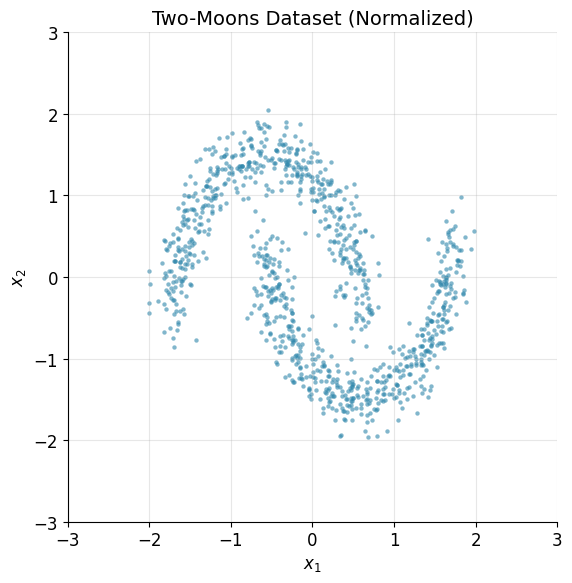

In [5]:
# Plot real data
plot_real_data(data, save_path=str(figures_path)+"/two_moons.png")

## The Forward Process: Gradually Adding Noise

To train a diffusion model, we define a **forward process** — a continuous transformation that gradually converts the data distribution $ p_0(x) $ into a standard Gaussian noise distribution. This is done by progressively adding Gaussian noise over a time interval $ t \in [0, 1] $.

At each time $ t $, a noised version of the data is defined as:
$$
x_t = \sqrt{\bar{\alpha}_t} \cdot x_0 + \sqrt{1 - \bar{\alpha}_t} \cdot \epsilon,
\quad \epsilon \sim \mathcal{N}(0, I)
$$
where:
- $ x_0 $ is a data point
- $ \epsilon $ is standard Gaussian noise
- $ \bar{\alpha}_t \in (0,1) $ controls the **signal-to-noise ratio** at time $ t $

The function $ t \mapsto \bar{\alpha}_t $ is called the **noise schedule**. It determines how rapidly the original structure is lost. Two common choices are:

1. **Linear schedule**: $ \bar{\alpha}_t = 1 - t $  
   Simple, but adds noise too quickly at the beginning, blurring fine details early.

2. **Cosine schedule**:  
   $$
   \bar{\alpha}_t = \cos^2\left( \frac{t + s}{1 + s} \cdot \frac{\pi}{2} \right), \quad s = 0.008
   $$  
   Introduced in DDIM, this schedule preserves high signal fidelity for longer, resulting in smoother transitions and higher-quality samples — especially when using few sampling steps.

We use the **cosine schedule** because:
- It adds noise **slowly at first**, allowing the model to learn from structured, slightly corrupted data
- It avoids sharp changes in the score field $ \nabla_x \log p_t(x) $
- It is empirically superior for **deterministic samplers** like DDIM

Below, we visualize both schedules. Note that:
- $ t = 0 $: pure data ($ \bar{\alpha}_0 \approx 1 $)
- $ t = 1 $: pure noise ($ \bar{\alpha}_1 \approx 0 $)
- The cosine schedule decays more slowly than linear, preserving signal longer.

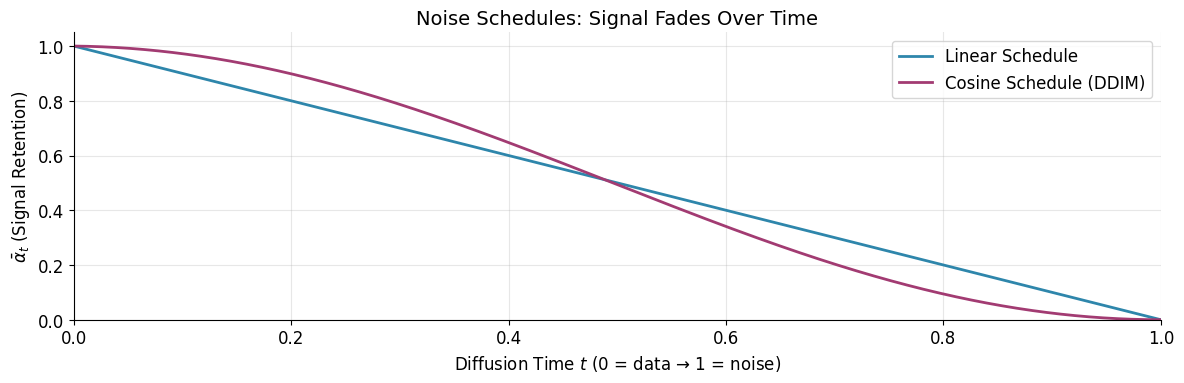

In [6]:
# Forward diffusion time: t ∈ [0, 1], where t=0 → data, t=1 → noise
t = torch.linspace(0.0, 1.0, 1000)

# Linear schedule: ᾱ_t = 1 - t
alpha_bar_linear = 1 - t

# Cosine schedule (DDIM)
s = 0.008
alpha_bar_cosine = (torch.cos((t + s) / (1 + s) * torch.pi / 2)) ** 2

# Plot
plt.figure(figsize=(12, 4))
plt.plot(t.numpy(), alpha_bar_linear.numpy(), label='Linear Schedule', linewidth=2)
plt.plot(t.numpy(), alpha_bar_cosine.numpy(), label='Cosine Schedule (DDIM)', linewidth=2)

plt.xlabel('Diffusion Time $t$ (0 = data → 1 = noise)', fontsize=12)
plt.ylabel('$\\bar{\\alpha}_t$ (Signal Retention)', fontsize=12)
plt.title('Noise Schedules: Signal Fades Over Time', fontsize=14)
plt.legend()
plt.grid(True, alpha=0.3)
plt.xlim(0, 1)
plt.ylim(0, 1.05)
plt.tight_layout()
plt.show()

## The Score Function: The Gradient of Surprise

To reverse the diffusion process, we need to know:  
> "Which direction should we move a noisy point $ x_t $ to make it more likely under the current distribution $ p_t(x) $?"

The answer is the **score function**:
$$
\nabla_x \log p_t(x)
$$
This vector field points in the direction of **steepest increase in log-density** — i.e., toward higher probability regions.

In physics, it's like a **force** pulling particles toward likely configurations.  
In optimization, it's the **gradient** we follow in Langevin dynamics.

But we don’t know $ p_t(x) $ — so we can’t compute the score directly. Instead, we train a neural network $ \epsilon_\theta(x_t, t) $ to predict the **noise** that was added at time $ t $. From this, we recover the score:
$$
\nabla_x \log p_t(x) = -\frac{1}{\sqrt{1 - \bar{\alpha}_t}} \cdot \epsilon_\theta(x_t, t)
$$
This is the key insight:  
> **Denoising is equivalent to score estimation.**

By training the model to predict noise, we are effectively learning the score — and thus, the reverse process.

## Time Conditioning: Why the Model Must Know "When"

The score $ \nabla_x \log p_t(x) $ depends on **when** in the diffusion process we are. At $ t=0 $, the data is clean — the score should preserve and refine structure. As $t \to 1$ , the data becomes increasingly corrupted by noise, and the score must guide samples back from randomness toward plausible configurations.

So the model must be **conditioned on time $ t $**. But $ t \in [0,1] $ is a scalar — if we feed it directly, the model might not learn smooth, well-calibrated behavior across time.

To help it, we use **positional encoding**, inspired by Transformers:
$$
\text{PE}(t) = \left[ \sin(t \cdot \omega_0), \cos(t \cdot \omega_0), \sin(t \cdot \omega_1), \cos(t \cdot \omega_1), \dots \right]
$$
where $ \omega_i $ are geometrically spaced frequencies.

This encoding:
- Allows the model to learn **smooth, periodic, and multi-scale** dependencies on $ t $
- Avoids discontinuities (e.g., if $ t=0.5 $ were just a number, small changes might cause big jumps)
- Is empirically more stable than raw $ t $ or MLP embeddings

While we won’t rerun the experiment here, prior work (e.g., DDPM, score-based models) shows that without such encoding, models often:
- Overfit to certain time steps
- Produce lower-quality samples
- Exhibit instability in early or late stages

So we use positional encoding as a **robust, standard practice** — a principled way to represent time.

## Training: Watching the Moons Emerge

Now that we have:
- The **data**
- The **noise schedule**
- The **score network**

We can train the model to predict noise at each time step.

The objective is simple: given a noised point $ x_t $ and its time $ t $, minimize the MSE between the **true noise** $ \epsilon $ and the **predicted noise** $ \epsilon_\theta(x_t, t) $:
$$
\mathcal{L} = \mathbb{E}_{x_0, t, \epsilon} \left[ \|\epsilon - \epsilon_\theta(x_t, t)\|^2 \right]
$$

We train for 20,000 steps, and every 1000 steps, we:
1. Sample from the current model using `ddim_sample`
2. Plot real vs generated samples
3. Update the loss curve

Below is the training loop. As it progresses, you’ll see the model go from generating pure noise → stretched blobs → clear two-moons structure.

Starting training on cpu...
Epochs: 20000, Batch size: 1024
Training:   0%|          | 0/20000 [00:00<?, ?it/s]Step 0 | Loss: 1.017


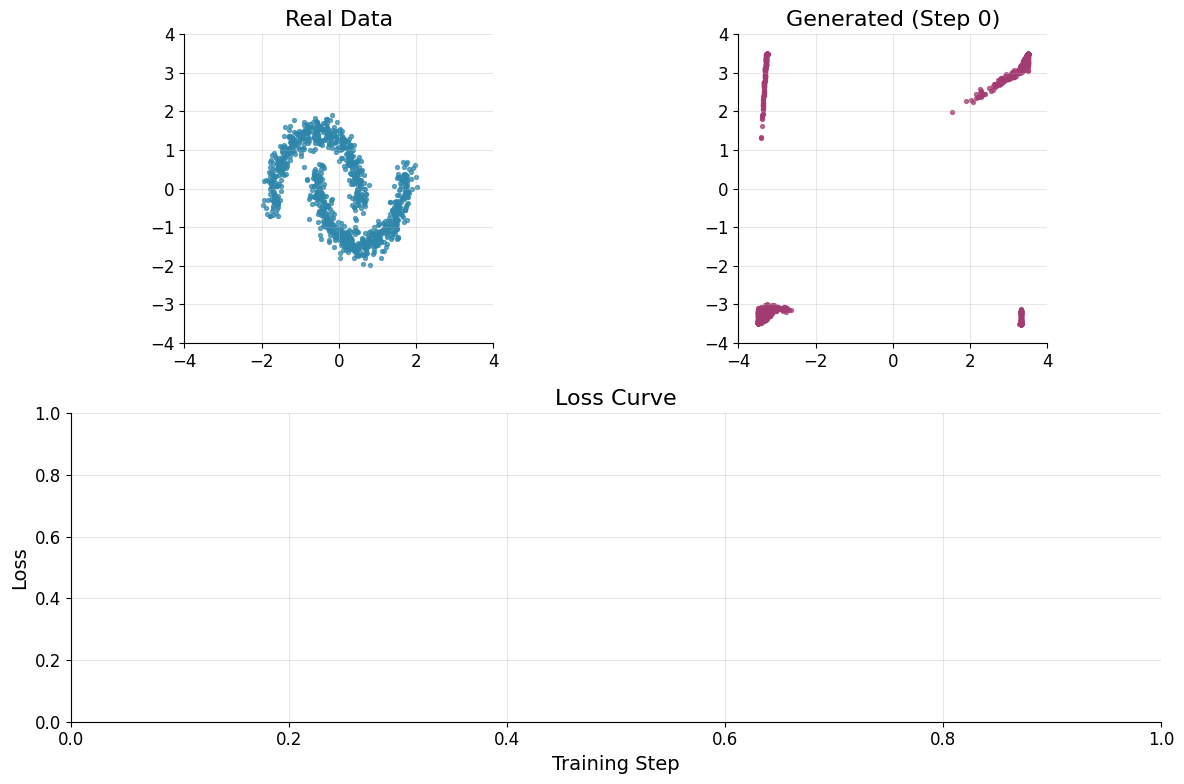

Training:   5%|▍         | 997/20000 [00:25<06:58, 45.40it/s]Step 1000 | Loss: 0.492


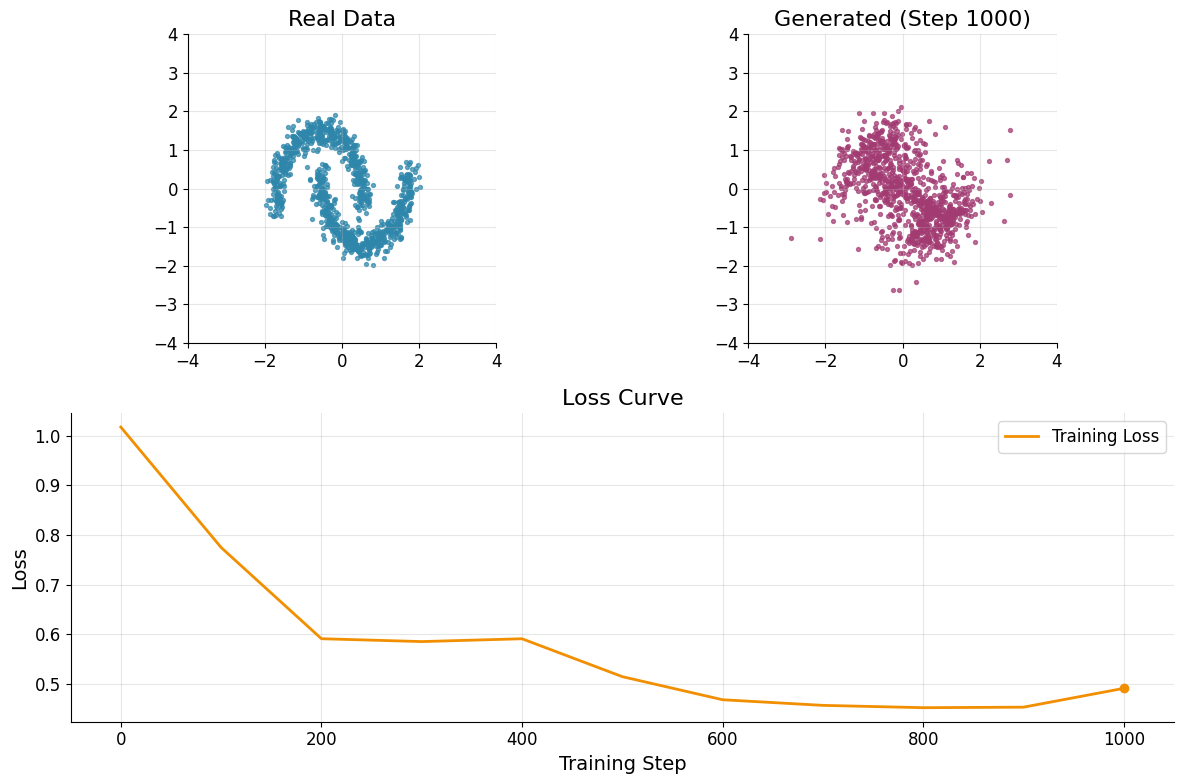

Training:  10%|▉         | 1999/20000 [00:52<08:27, 35.48it/s]Step 2000 | Loss: 0.470


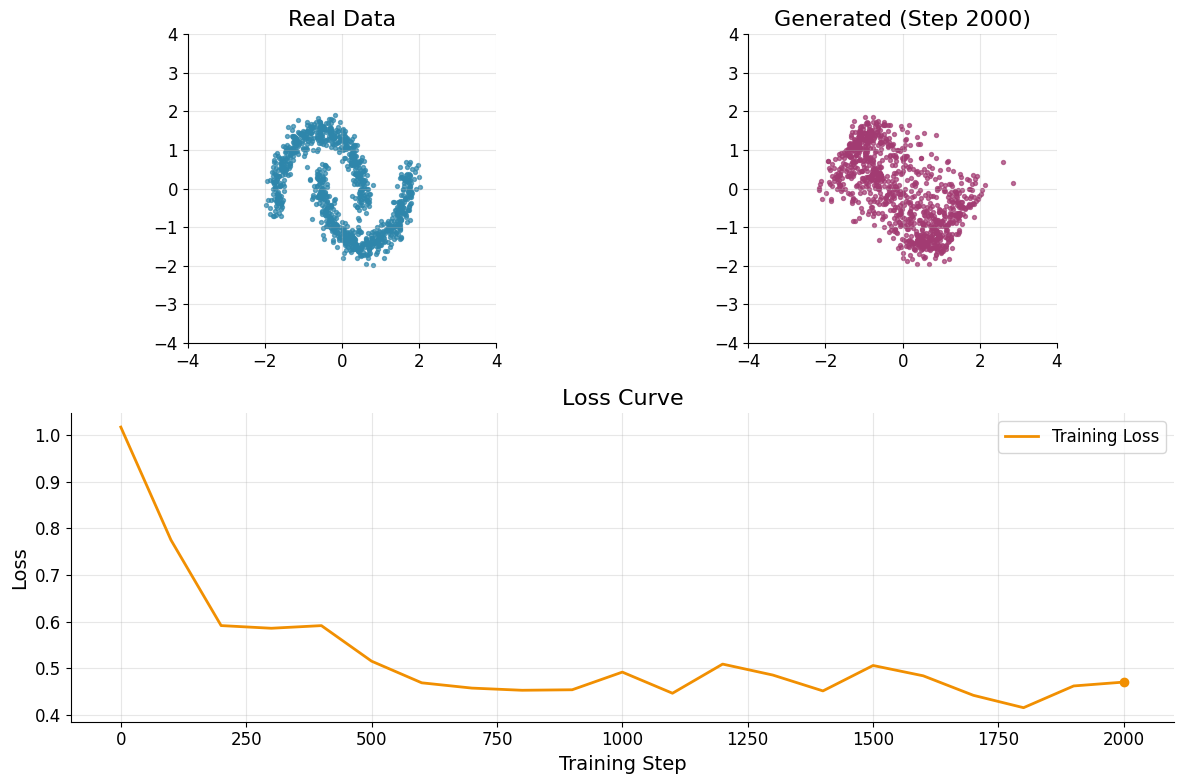

Training:  15%|█▍        | 2995/20000 [01:31<06:30, 43.52it/s]Step 3000 | Loss: 0.443


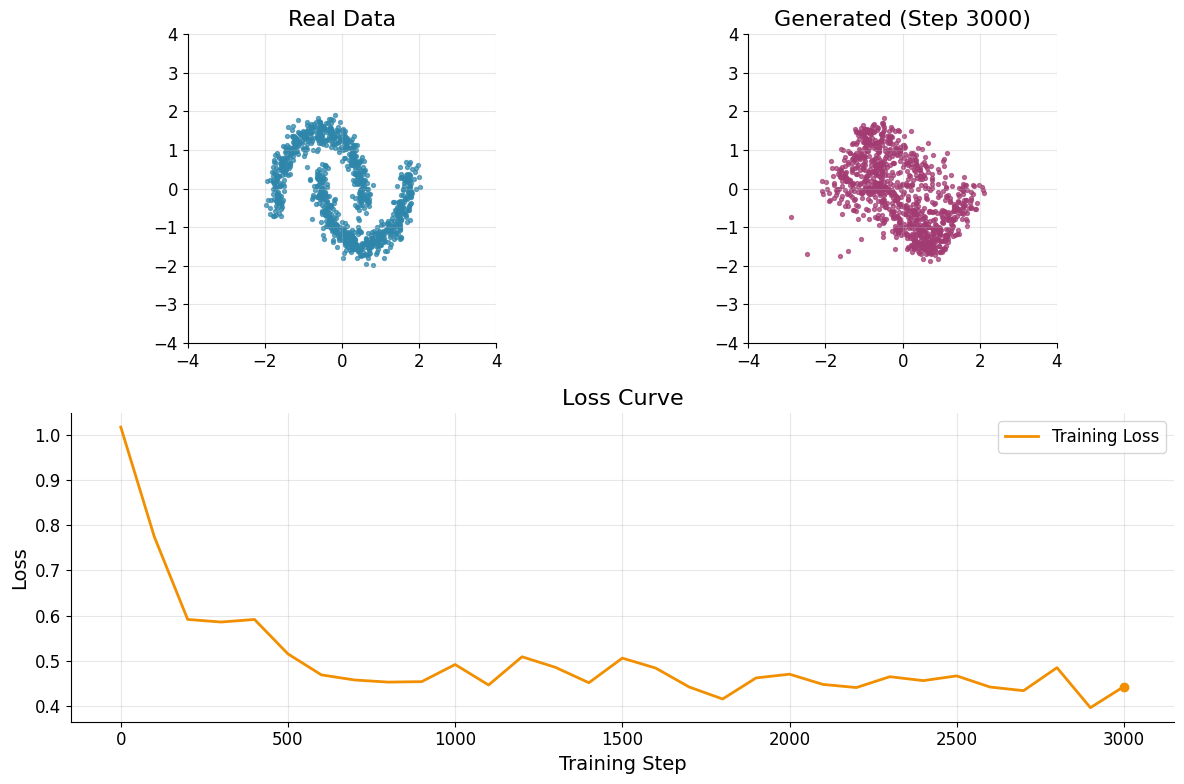

Training:  20%|█▉        | 3996/20000 [02:17<06:31, 40.91it/s]Step 4000 | Loss: 0.418


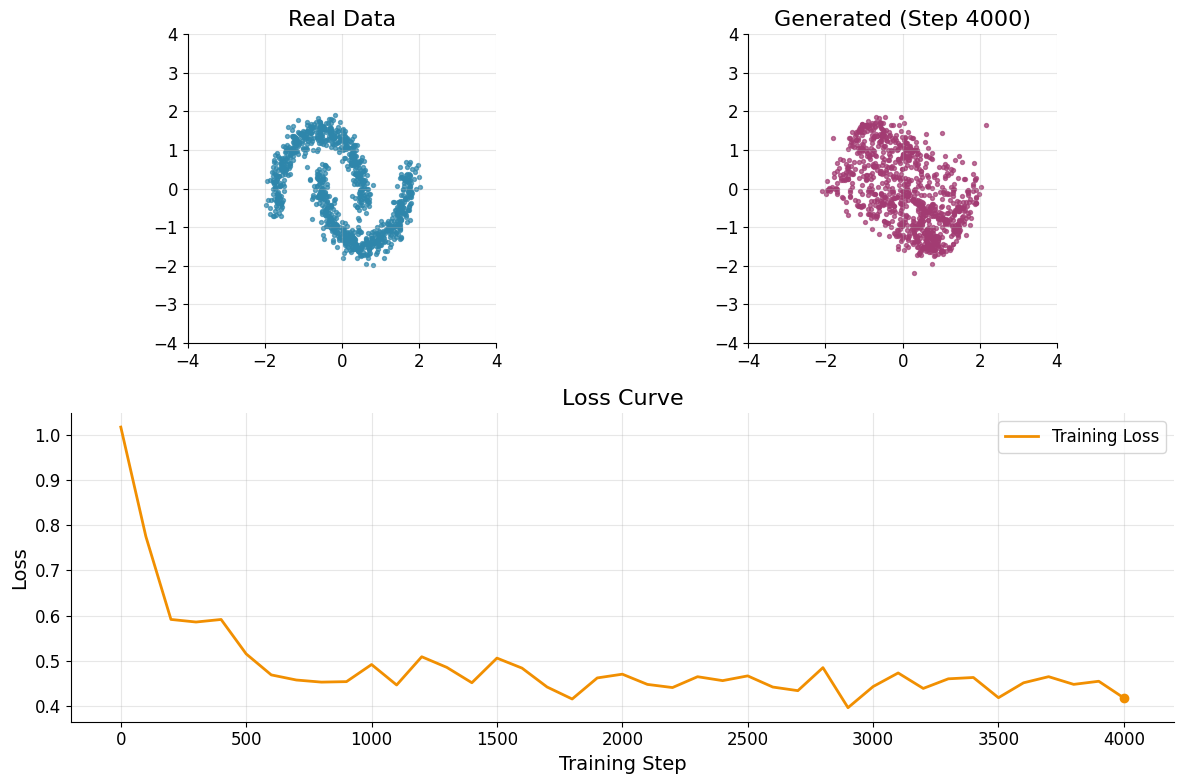

Training:  25%|██▍       | 4998/20000 [02:47<07:47, 32.12it/s]Step 5000 | Loss: 0.414


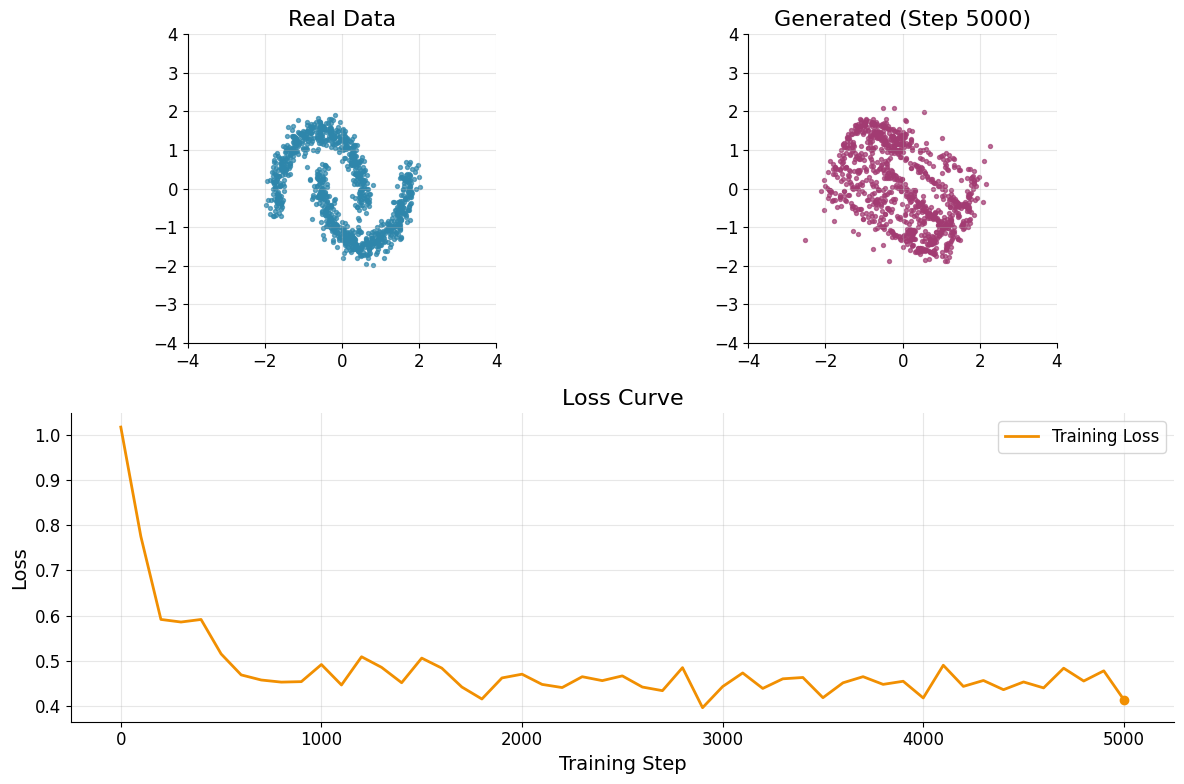

Training:  30%|██▉       | 5999/20000 [03:14<06:56, 33.64it/s]Step 6000 | Loss: 0.474


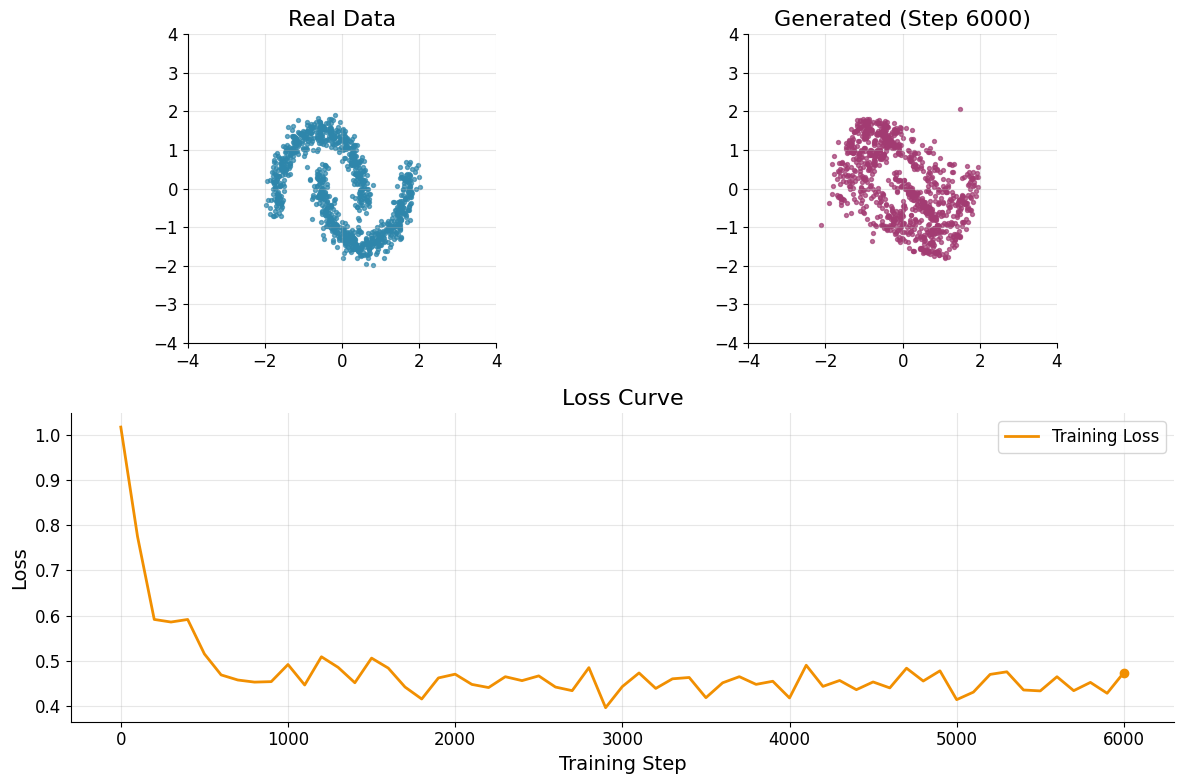

Training:  35%|███▍      | 6999/20000 [03:43<06:21, 34.08it/s]Step 7000 | Loss: 0.442


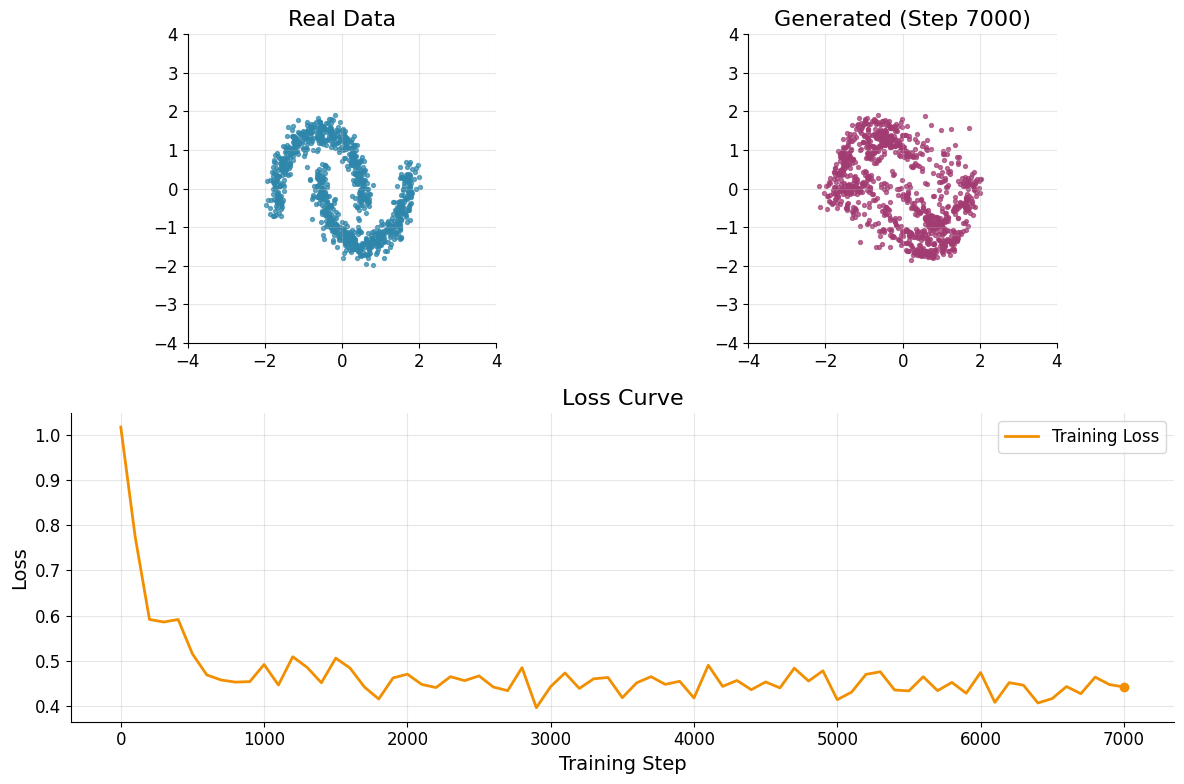

Training:  40%|███▉      | 7996/20000 [04:10<03:51, 51.89it/s]Step 8000 | Loss: 0.459


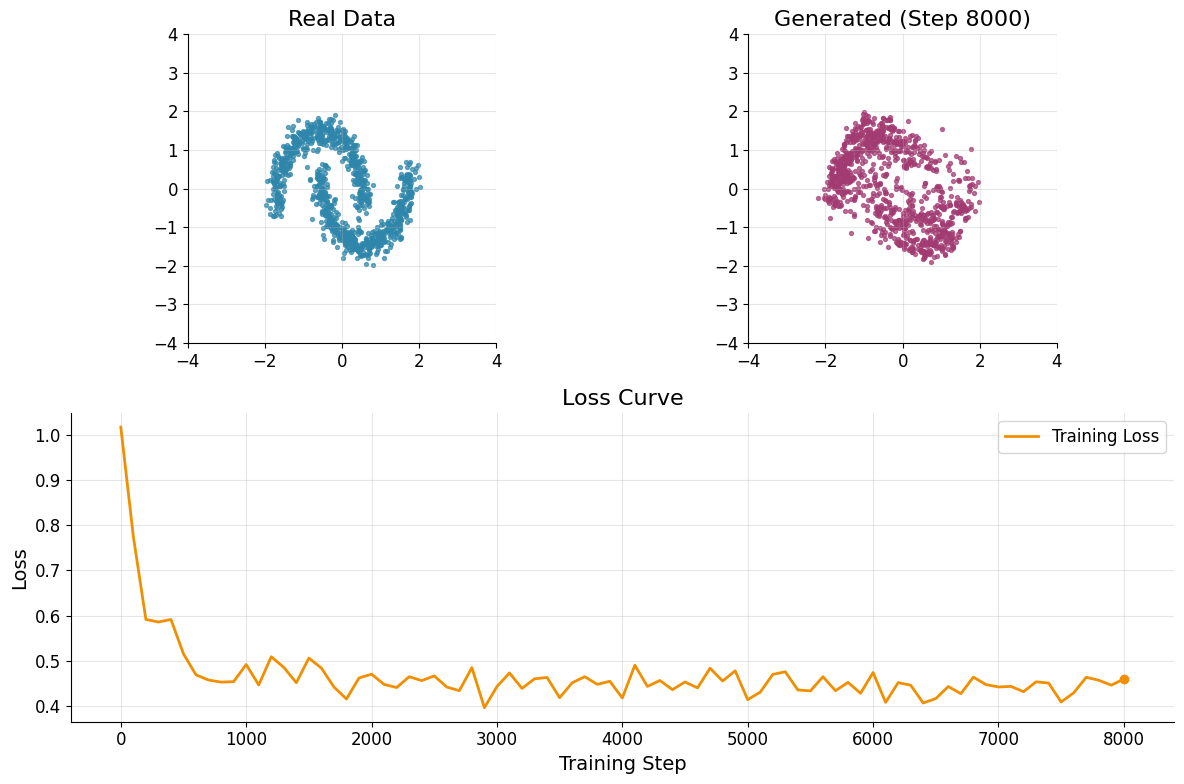

Training:  45%|████▍     | 8999/20000 [04:37<03:58, 46.13it/s]Step 9000 | Loss: 0.442


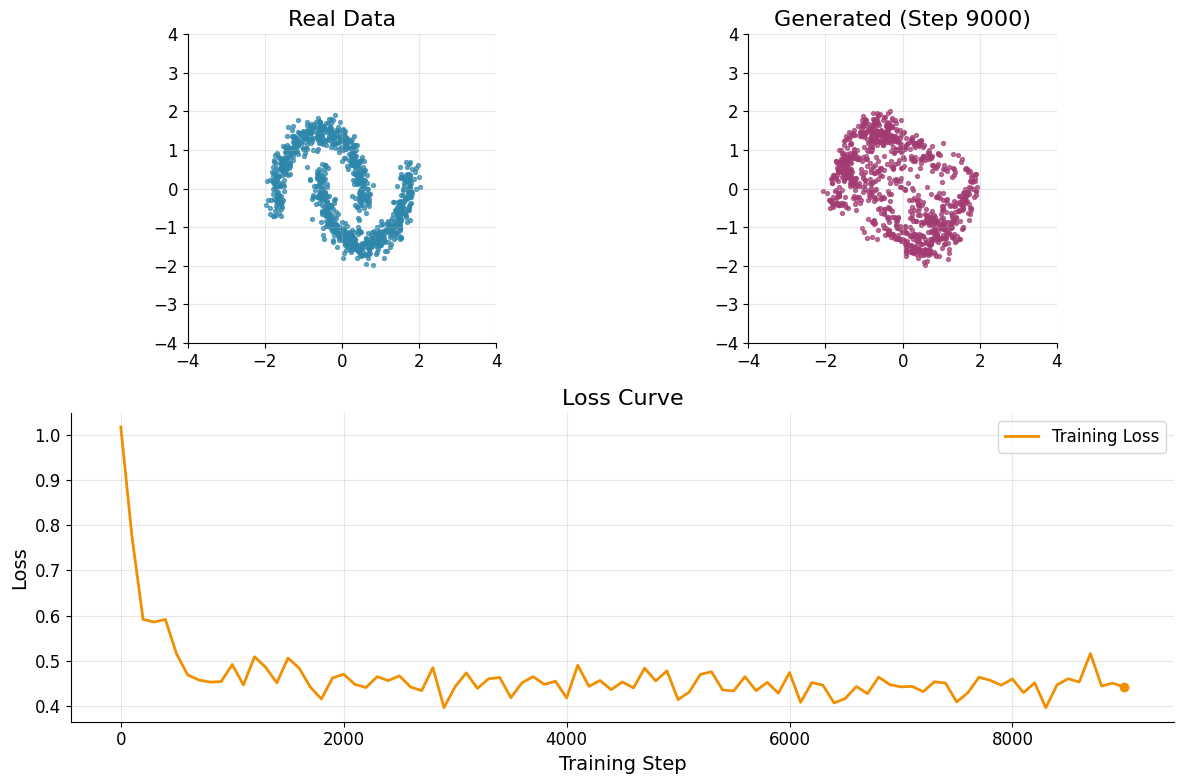

Training:  50%|████▉     | 9996/20000 [05:02<03:20, 49.92it/s]Step 10000 | Loss: 0.450


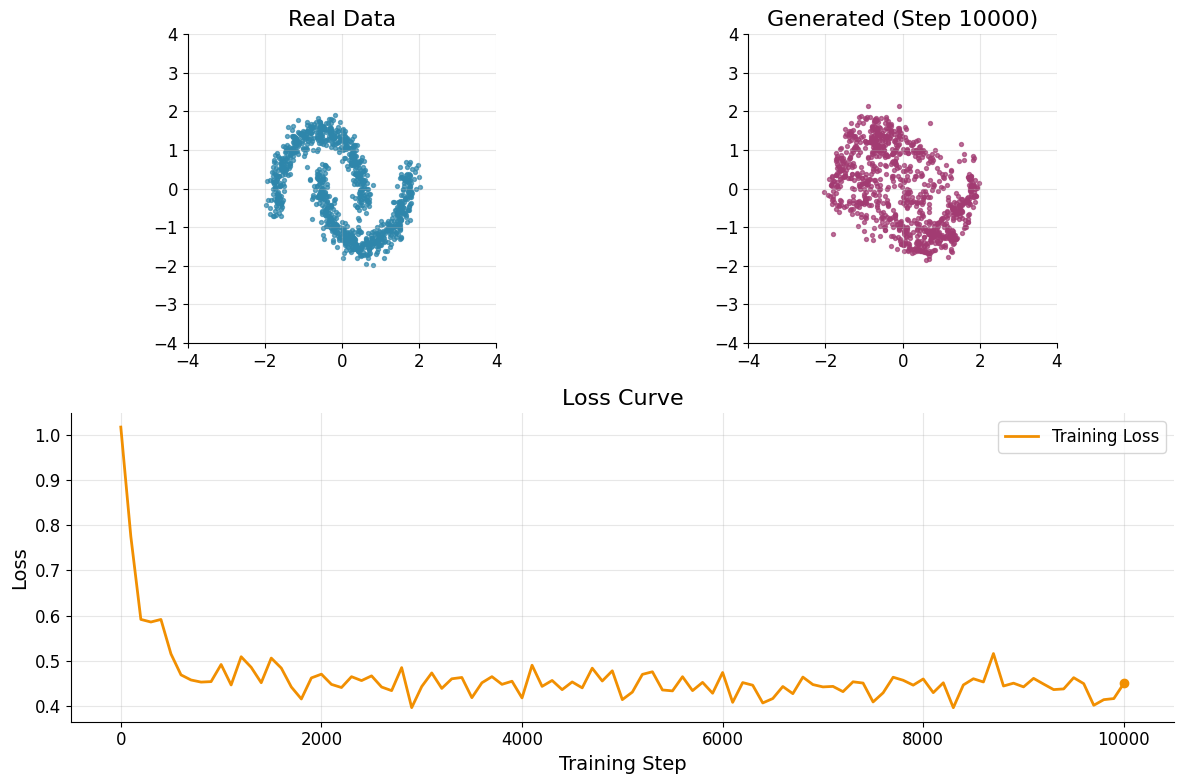

Training:  55%|█████▍    | 10998/20000 [05:28<04:28, 33.47it/s]Step 11000 | Loss: 0.432


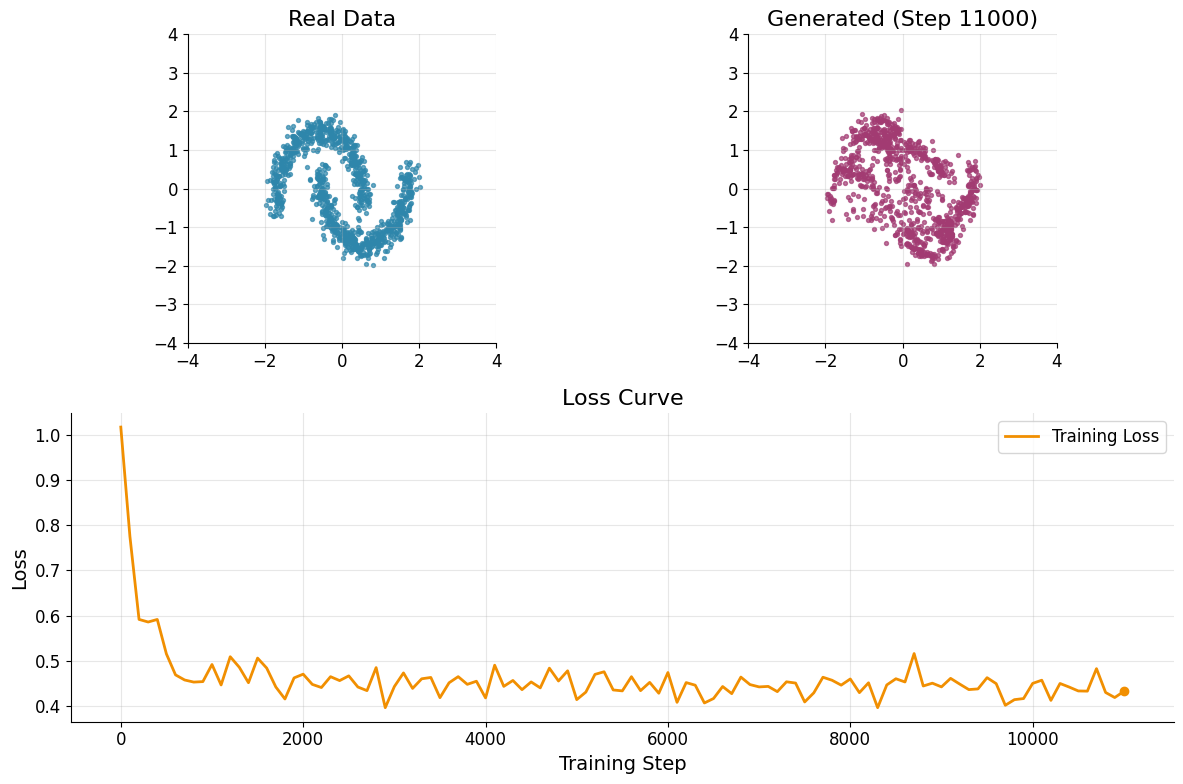

Training:  60%|█████▉    | 11999/20000 [05:53<02:37, 50.86it/s]Step 12000 | Loss: 0.468


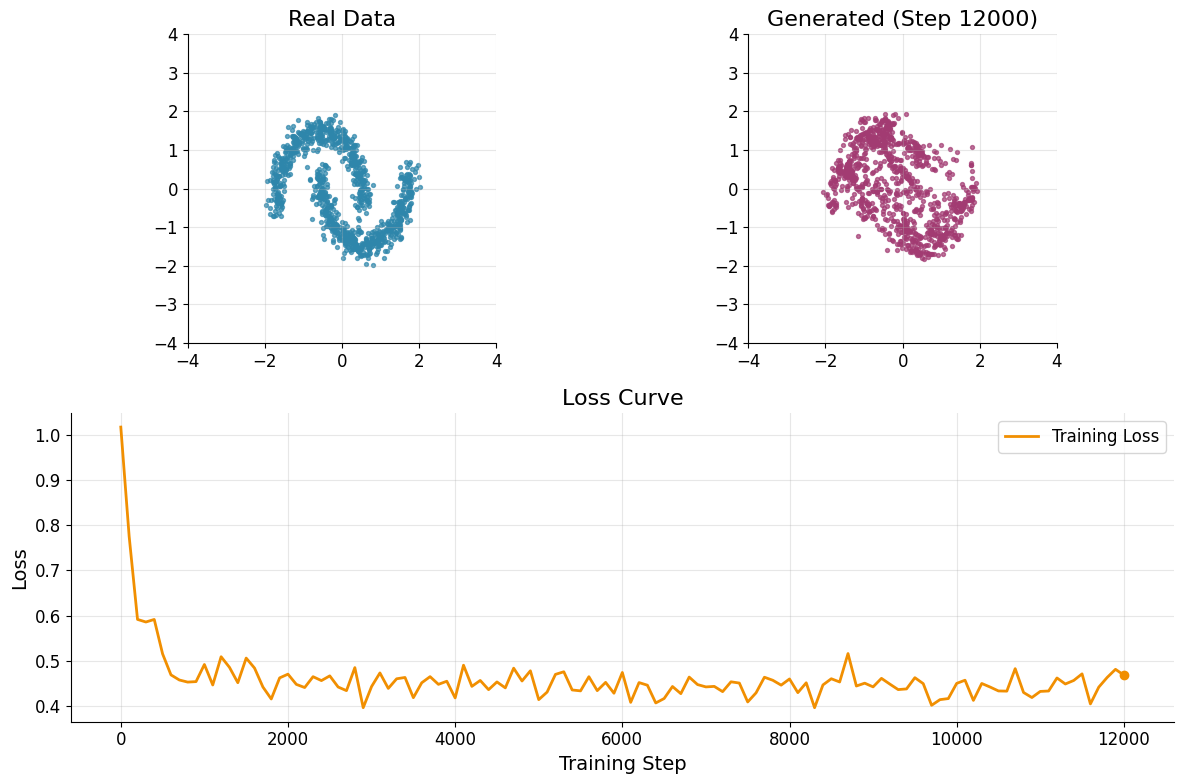

Training:  65%|██████▍   | 12998/20000 [06:21<03:05, 37.75it/s]Step 13000 | Loss: 0.436


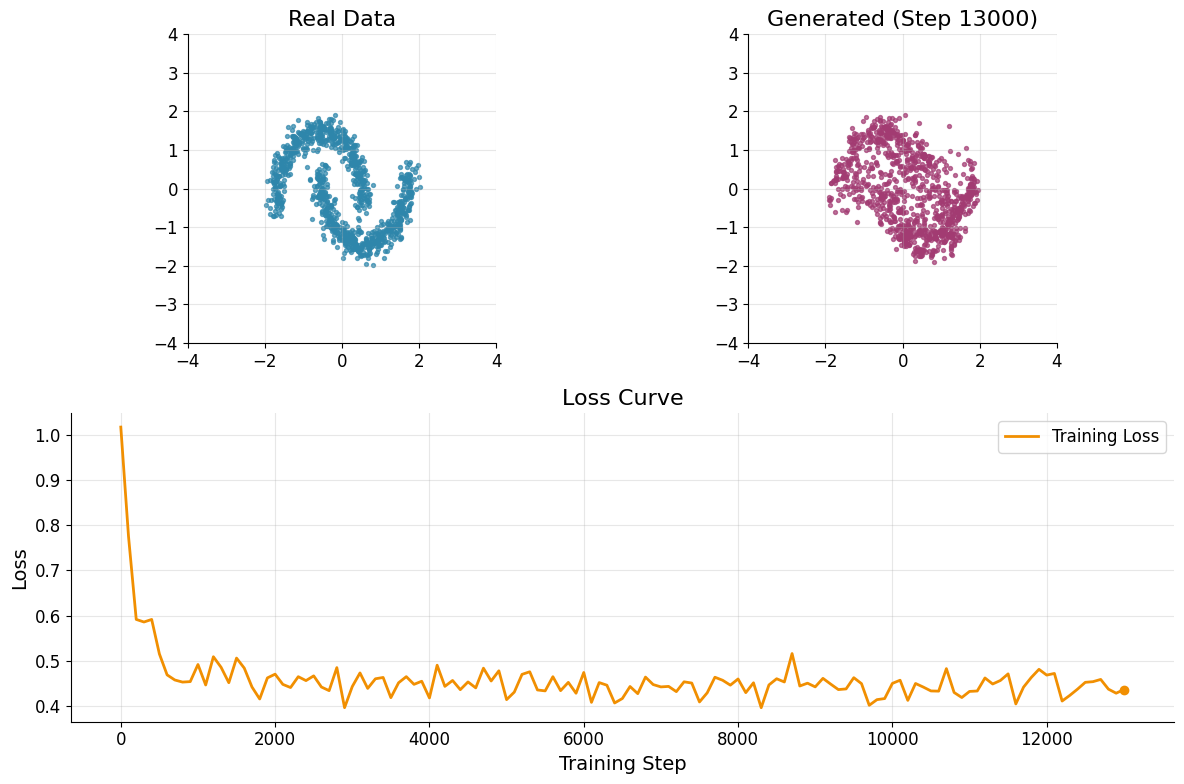

Training:  70%|██████▉   | 13999/20000 [06:49<02:41, 37.18it/s]Step 14000 | Loss: 0.441


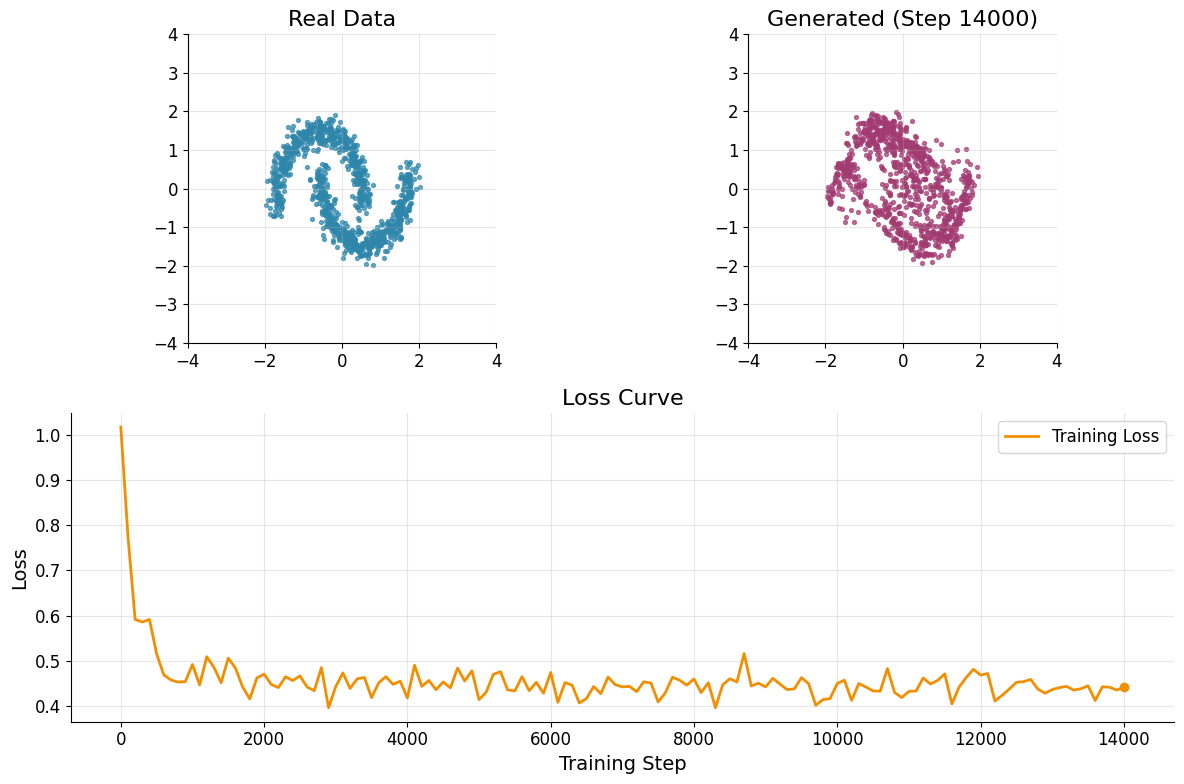

Training:  75%|███████▍  | 14997/20000 [07:14<01:47, 46.72it/s]Step 15000 | Loss: 0.430


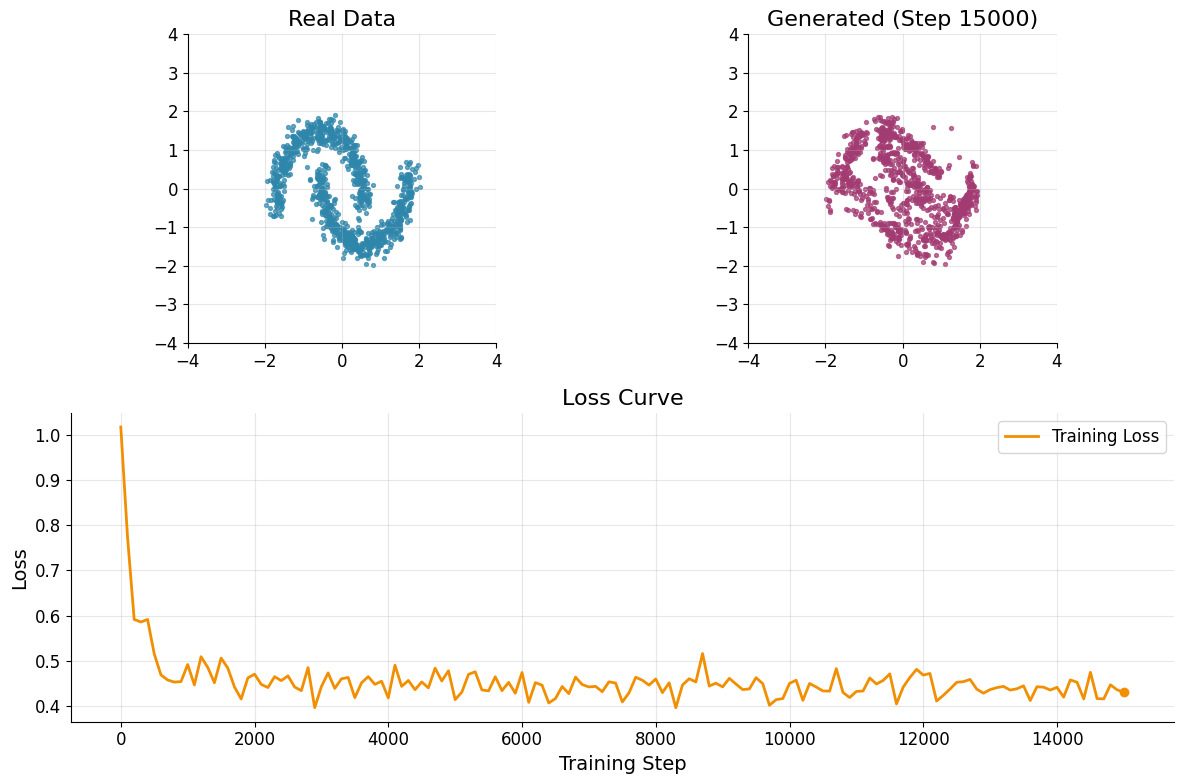

Training:  80%|███████▉  | 15995/20000 [07:52<01:49, 36.65it/s]Step 16000 | Loss: 0.455


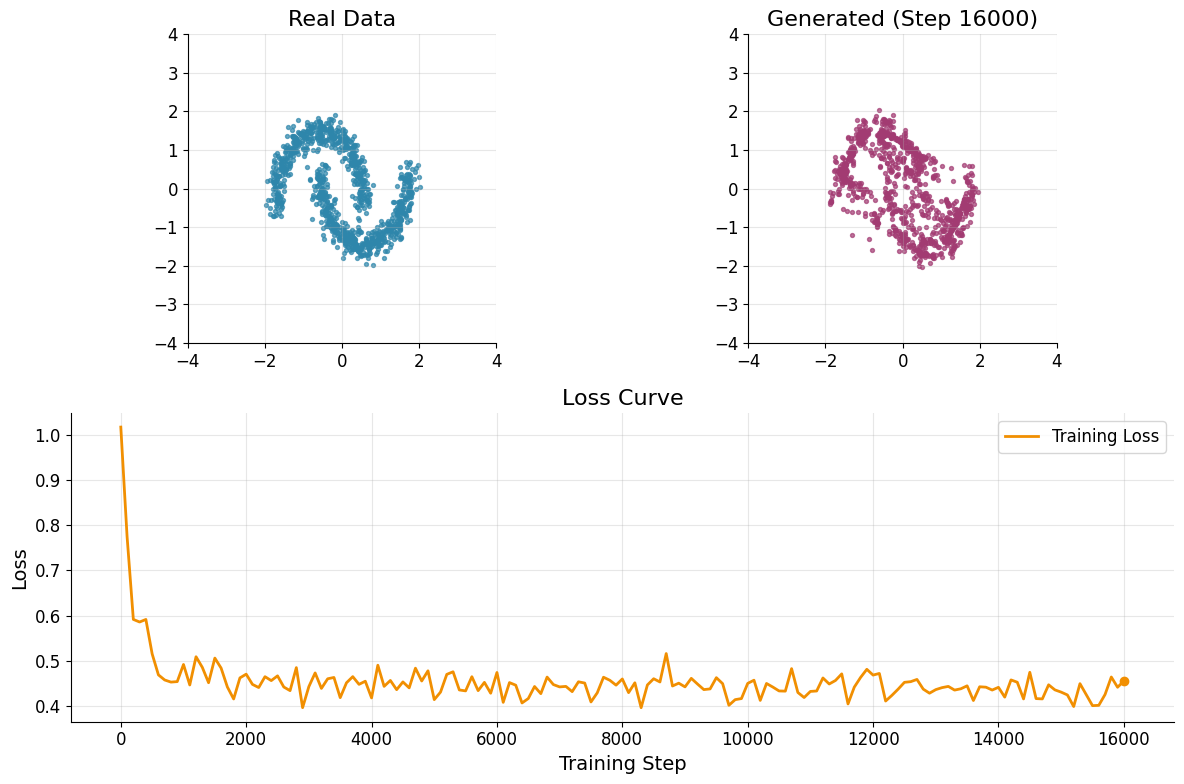

Training:  85%|████████▍ | 16998/20000 [08:25<01:10, 42.39it/s]Step 17000 | Loss: 0.427


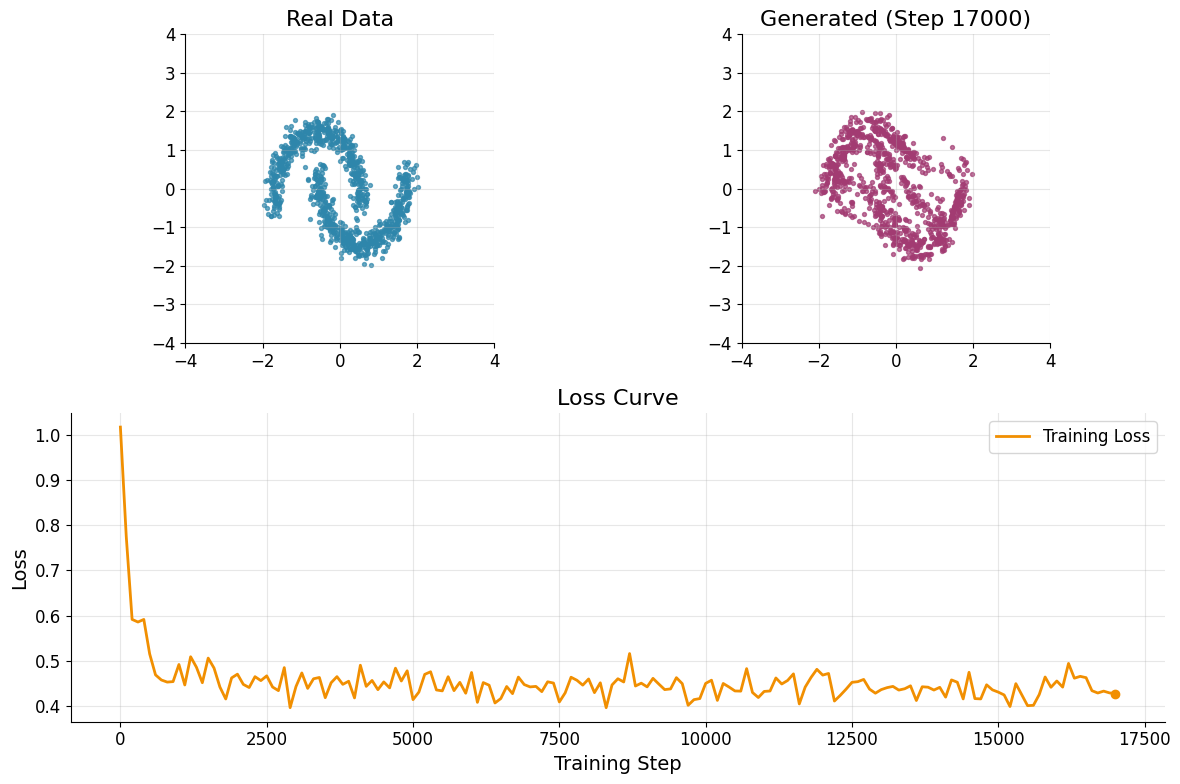

Training:  90%|████████▉ | 17998/20000 [08:49<00:38, 51.39it/s]Step 18000 | Loss: 0.432


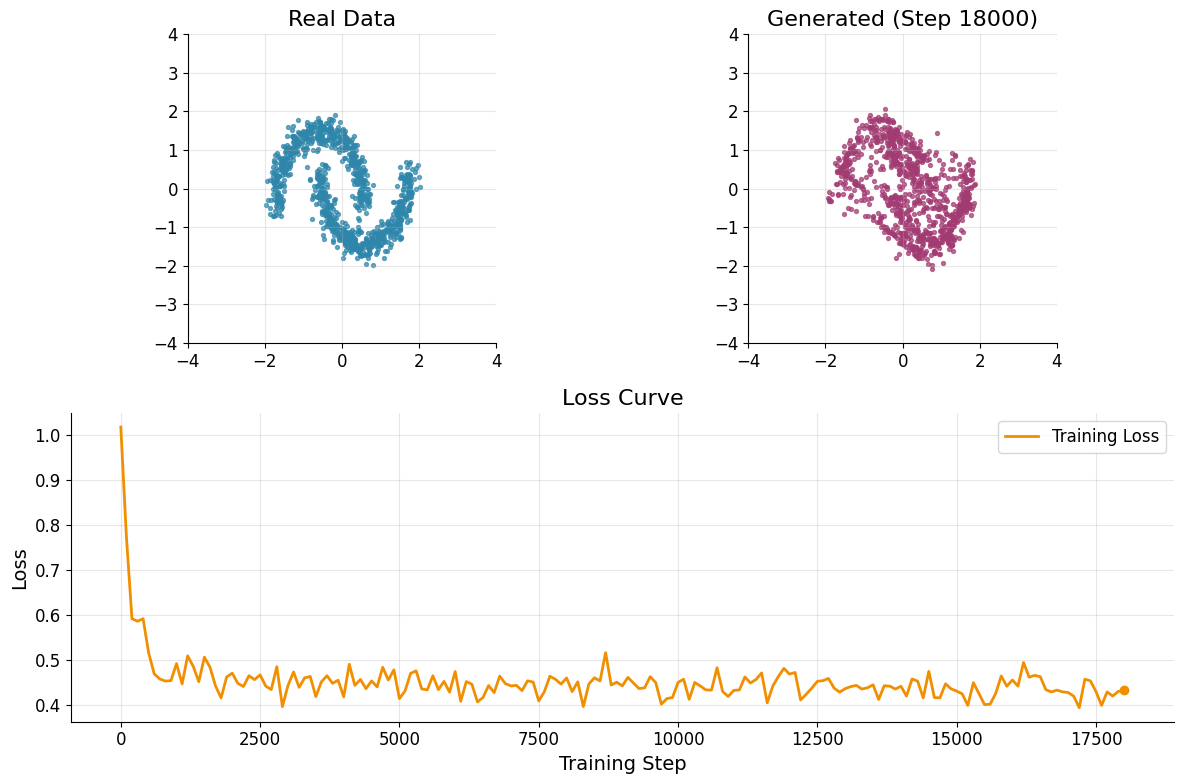

Training:  95%|█████████▍| 18993/20000 [09:13<00:17, 56.10it/s]Step 19000 | Loss: 0.432


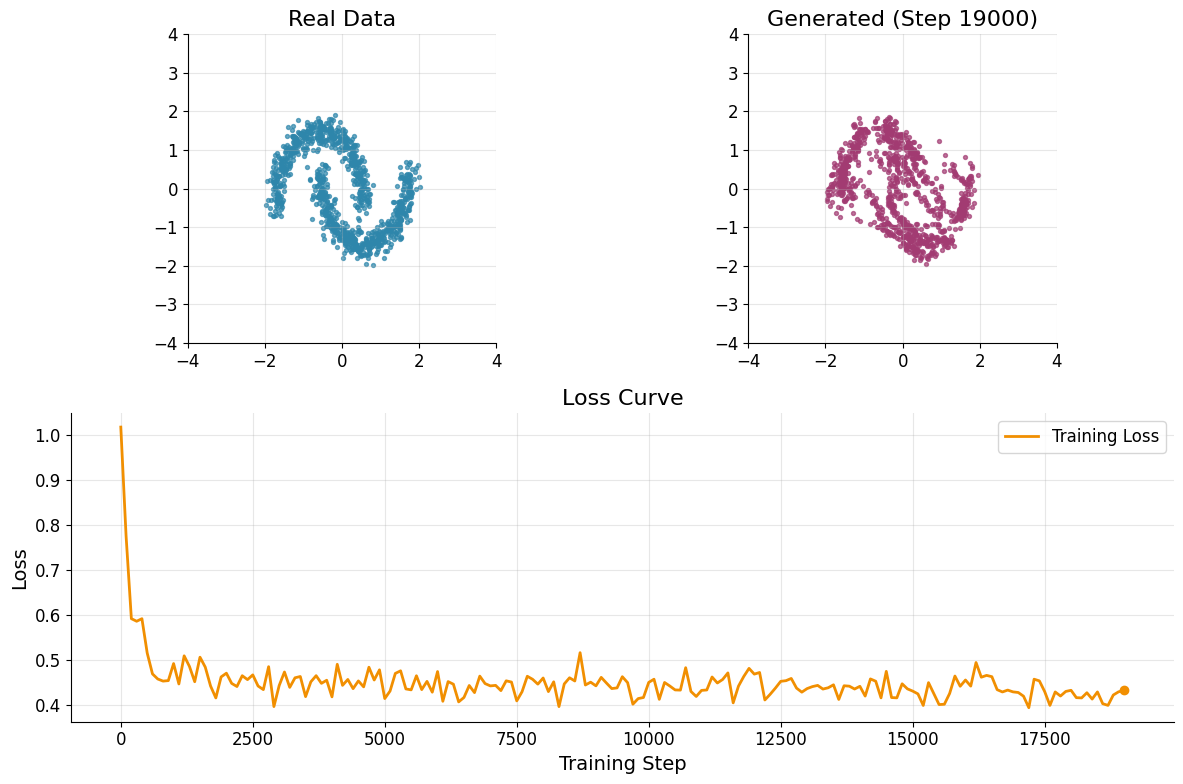

Training: 100%|██████████| 20000/20000 [09:41<00:00, 34.41it/s]


In [7]:
#Diffusion training 
model, history = train_model(
    n_epochs=20000,  
    batch_size=1024,
    learning_rate=1e-4,
    device='cpu',
    checkpoint_interval=1000
)


## Sampling: Reversing the Process with DDIM

Now that the model is trained, we can generate new samples by reversing the diffusion process. But there is a key insight:

> **There are many ways to reverse diffusion** — not just one.

The method we have been using is called **DDIM (Denoising Diffusion Implicit Model)**, introduced by Song et al. (2020). It is a **deterministic** sampler that allows high-quality generation in **fewer steps** than the original DDPM (Denoising Diffusion Probabilistic Models) sampler.

### Why "Implicit"?
Unlike DDPM, which defines a Markov chain with stochastic transitions, DDIM defines a **non-Markovian**, deterministic process. This means:
- No randomness in the reverse step (once noise prediction is fixed)
- Samples are **reproducible**: same noise → same output
- Enables **few-step sampling** (e.g., 20-50 steps) without quality loss

This is why DDIM is ideal for visualization and controlled generation.


### How Does DDIM Work?

At a high level, DDIM reverses the forward process by:
1. Predicting the original data $ x_0 $ from $ x_t $
2. Using that prediction to reconstruct $ x_{t-1} $ deterministically

Mathematically, it uses:
$$
x_{t-1} = \sqrt{\bar{\alpha}_{t-1}} \cdot x_0^{\text{pred}} + \sqrt{1 - \bar{\alpha}_{t-1}} \cdot \epsilon_\theta(x_t, t)
$$
where $ x_0^{\text{pred}} $ is recovered from:
$$
x_0^{\text{pred}} = \frac{x_t - \sqrt{1 - \bar{\alpha}_t} \cdot \epsilon_\theta(x_t, t)}{\sqrt{\bar{\alpha}_t}}
$$

This avoids the stochastic "drift + noise" update of DDPM, making it faster and more stable.

We use DDIM because:
- It produces **sharp, high-fidelity samples**
- It is **deterministic**, so we can study individual trajectories
- It works well with **continuous time** and **cosine schedules**



### Other Samplers: A Brief Taxonomy

You might have seen other names in diffusion literature. Here is a quick guide:

| Sampler | Full Name | Stochastic? | Use Case |
|--------|-----------|------------|---------|
| **DDPM** | Denoising Diffusion Probabilistic Model | Yes | Original, slow but stable |
| **DDIM** | Denoising Diffusion Implicit Model | No (deterministic) | Fast sampling, interpolation |
| **PNDM** | Pseudo Numerical Methods | No | Fast, but less common now |
| **Langevin** | Score-based Langevin Dynamics | Yes | Used in score-based models, requires many small steps |
| **Ancestral Sampling** | — | Yes | Stochastic, diverse samples, but noisier |




### Summary

We use **DDIM** because it is:
- Fast
- Deterministic
- High-quality
- Compatible with continuous time

## Analysis & Debugging: Stability and Outliers

Even with a well-trained model, we occasionally observe extreme values (e.g., near (-5,5)). This is due to:
- **Numerical sensitivity** when $ \bar{\alpha}_t \approx 0 $ (division by small number)
- **Model extrapolation** beyond training distribution

Our solution: **clipping**:
```python
x0_pred = torch.clamp(x0_pred, -3.5, 3.5)
```


Sample range: x1 [-2.004, 2.000], x2 [-2.121, 2.010]
Outliers beyond ±3.5: 0/1000 points


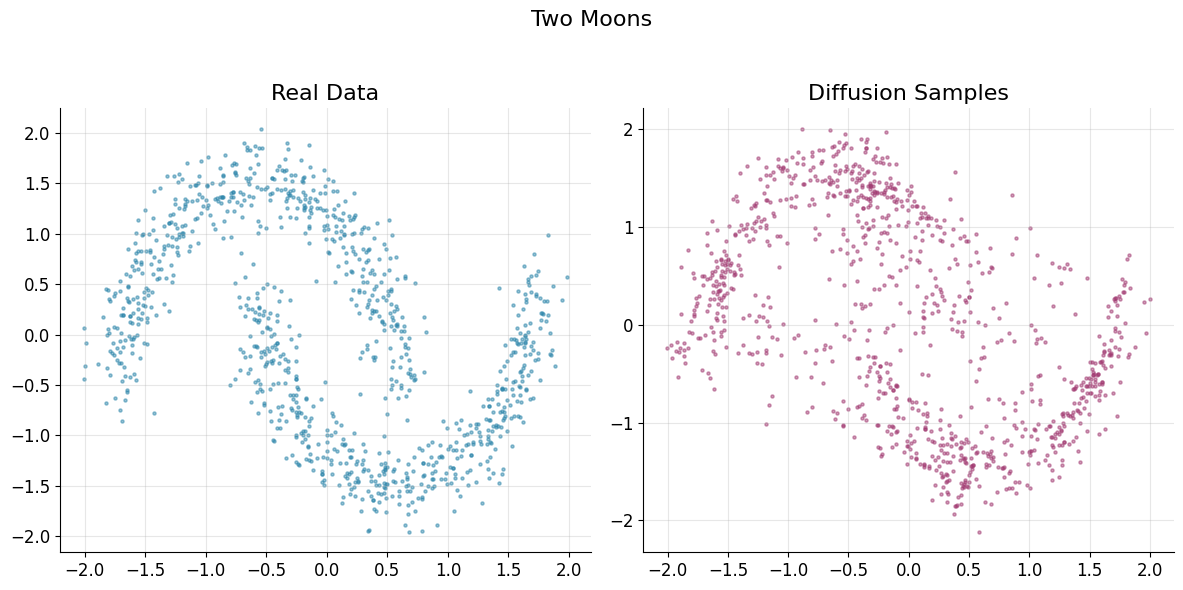

In [23]:
# Generate final samples
x_diff = ddim_sample(model, steps=250, n=1000, device='cpu')
x_d = x_diff.cpu().numpy()

# Check range
print(f"Sample range: x1 [{x_diff[:,0].min():.3f}, {x_diff[:,0].max():.3f}], "
      f"x2 [{x_diff[:,1].min():.3f}, {x_diff[:,1].max():.3f}]")

# Count outliers
threshold = 3.5
outliers = (x_diff < -threshold) | (x_diff > threshold)
n_outliers = outliers.any(axis=1).sum()
print(f"Outliers beyond ±{threshold}: {n_outliers}/{len(x_diff)} points")

# Plot only if outliers exist
if n_outliers > 0:
    plt.figure(figsize=(6,6))
    plt.scatter(x_d[:,0], x_d[:,1], c=get_color_palette()['generated_data'], alpha=0.6)
    outlier_mask = outliers.any(axis=1)
    plt.scatter(x_d[outlier_mask, 0], x_d[outlier_mask, 1], 
                s=100, c=get_color_palette()['accent1'], label='Outliers')
    plt.legend()
    plt.title("Generated Samples (with outliers)")
    plt.show()


# Create figure and axes objects
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

# Add the main title for the entire figure
fig.suptitle("Two Moons", fontsize=16)

# Plot on specific axes
ax1.scatter(data[:,0], data[:,1], s=5, c=get_color_palette()['real_data'], alpha=0.5)
ax1.set_title("Real Data")

ax2.scatter(x_d[:,0], x_d[:,1], s=5, c=get_color_palette()['generated_data'], alpha=0.5)
ax2.set_title("Diffusion Samples")

fig.tight_layout(rect=[0, 0, 1, 0.95]) # Leave space at the top
plt.show()

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=de7d40e8-6998-4e65-8626-6720908f4576' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>